# Web Scraping and Introductory Data Analysis
bla bla bla

## Part 1: Web Scraping 

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [2]:
WEB_URL = "https://etherscan.io/txs"
TRX_TABLE_XPATH_HEAD = "//table[@class='table table-hover table-align-middle mb-0']/thead/tr/th"
TRX_TABLE_XPATH_BODY = "//table[@class='table table-hover table-align-middle mb-0']/tbody/tr"
ETHER_SCAN_CSV_FILE = "etherscan.csv"
NUM_OF_BLOCKS = 10


We begin by initializing a WebDriver using Selenium. Specifically, we use the Firefox WebDriver to instantiate a Firefox browser instance. This WebDriver will facilitate interactions with web elements. The WebDriver navigates to the [Etherscan.io](https://etherscan.io/txs).  
An assertion is used to verify that the title of the webpage contains the keyword "Ethereum". This step ensures that the WebDriver successfully loaded the expected webpage.  
Also it is good to mention that the webdriver will wait for a page to load by default via .get() method before attempting to scrape the data.

In [3]:
driver = webdriver.Firefox()
def setupWebDriver():
    driver.get(WEB_URL)
    assert "Ethereum" in driver.title

setupWebDriver()

The getTrxTableHeaders function extracts transactions table headers from HTML source code using the table's id. It modifies the extracted headers to match a specific format and returns the modified header as a list.  
The getTrxTableBody function extracts the body of a transaction table from HTML source code using Beautiful Soup. It iterates through each row of the table, extracts the text from each cell, removes newline characters. Additionally, it captures the block number from the first row of the table. 

In [4]:
def getTrxTableHeaders(html_src):
    trx_table_head = html_src.find(id = "ContentPlaceHolder1_theadAllTransactionTable").find_all('th')
    header = [header.get_text().replace("\n", "") for header in trx_table_head]
    header[2] = "Method"
    header.pop(0)
    header.pop(5)
    header.insert(3, "Date")
    header.insert(5, "Local Time")
    header.append("Gas Price")
    return header

def getTrxTableBody(rows_elements, html_src):
    trx_table_body = html_src.find('table')
    trx_table_body = trx_table_body.find_all('tr')
    block_number = 0
    for i in range(1, len(trx_table_body)):
        rows = trx_table_body[i].find_all('td')
        element = [elem.get_text() for elem in rows]
        element = list(map(lambda x: x.replace("\n", ""), element))
        element.pop(8)
        element.pop(0)
        if i == 1:
            block_number = int(element[2])
        rows_elements.append(element)
    return rows_elements, block_number

In this part we iterate through the transaction table, continuously fetching data until a certain condition is met. We click on the "Next" button in order to implement pagination handling to navigate through the pages and collect the last 10 blocks' transactions data. In this case that certain condition is the block number; At each iteration we get the first row's block number and compare it to the latest block number that we have.  
In the end we save the data into a DataFrame.

In [5]:
def saveTransactionsToDp(header, body):
    transactionsDf = pd.DataFrame(body, columns=header)
    transactionsDf.to_csv(ETHER_SCAN_CSV_FILE, mode='a', header=False, index=False)
    return transactionsDf
    
def scrapeWebPage():
    html_src = BeautifulSoup(driver.page_source, 'html.parser')
    header = getTrxTableHeaders(html_src)
    rows_elements = []
    body, latest_block_number = getTrxTableBody(rows_elements, html_src)
    while True:
        html_src = BeautifulSoup(driver.page_source, 'html.parser')
        body, block_number = getTrxTableBody(body, html_src)
        next_button = driver.find_element(By.XPATH, '//a[@aria-label="Next"]')
        next_button.click()
        if block_number == latest_block_number - NUM_OF_BLOCKS:
            break
    transactionsDf = saveTransactionsToDp(header, body)
    driver.close()
    return latest_block_number, transactionsDf


In [6]:
latest_block_number, transactionsDf = scrapeWebPage()
def saveToCsvFile(transactionsDf):
    transactionsDf.to_csv(ETHER_SCAN_CSV_FILE, index=False)
    
saveToCsvFile(transactionsDf)

## Part 2: Data Analysis

#### Clean Transactions Data

In [7]:
transactionsDf_raw = transactionsDf.copy()

In [8]:
display(transactionsDf)

,Txn Hash,Method,Block,Date,Age,Local Time,From,To,Value,Txn Fee,Gas Price
0,0x45665904ea1ad457a00104484211567361d699700910...,Transfer,19391882,2024-03-08 17:17:11,14 secs ago,1709918231,rsync-builder.eth,Fee Recipient: 0x7a1...0D6,0.115041986 ETH,0.00151679,72.2282514
1,0x23baaff54529eb9433395c09186a6aab14b3d795e6d7...,0x415565b0,19391882,2024-03-08 17:17:11,14 secs ago,1709918231,0x0295f3d9...009AdB469,0x: Exchange Proxy,0.076632267 ETH,0.01857194,72.2292514
2,0xfe631108c4ba9d9a0ddde737c87075af8c0150ed2641...,0x00000195,19391882,2024-03-08 17:17:11,14 secs ago,1709918231,0x345F6872...3B84cd5e1,Socket: Gateway,0.065717788 ETH,0.00538931,72.2292514
3,0x513037d74c25d78639b95ac9b348fe6a4ad499eac7f0...,Execute,19391882,2024-03-08 17:17:11,14 secs ago,1709918231,0x1d3990ef...78D752771,Uniswap: Universal Router,0.109898427 ETH,0.01101452,72.2292514
4,0x6e4a06544105be05188b232c5e218be7c1d7b252f3bd...,Transfer,19391882,2024-03-08 17:17:11,14 secs ago,1709918231,0xD0311426...25F96D077,0x49fbabfE...10a4F3697,0.25544089 ETH,0.00151681,72.2292514
...,...,...,...,...,...,...,...,...,...,...,...
3495,0xf1ccb31f6a711974a78506d6a3776bafd4e589df8b8d...,Transfer,19391872,2024-03-08 17:15:11,4 mins ago,1709918111,Coinbase 3,0x955Dd106...1771B4381,0.0255627 ETH,0.00157083,74.80172689
3496,0x58dea1fc45126ecf1519af3aaf68a7fbb888db48d4b5...,Approve,19391872,2024-03-08 17:15:11,4 mins ago,1709918111,0x54c18afD...66ff867A1,0x24708f06...A64773c6E,0 ETH,0.00345,74.80172689
3497,0xfe382ca8b43b564576f89e3e239faff2df4f025a7fdb...,Transfer,19391872,2024-03-08 17:15:11,4 mins ago,1709918111,Coinbase 6,0xe499412E...3d64173aE,0.12649321 ETH,0.00157083,74.80172689
3498,0x7e050414fc1114f2bfeef28bfd45309ef9f3ee88ae00...,Transfer,19391872,2024-03-08 17:15:11,4 mins ago,1709918111,0xc4017033...4a95b1a1b,IMMUTABLE X: IMX Token,0 ETH,0.00223507,74.80172689


In [9]:
transactionsDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Txn Hash    3500 non-null   object
 1   Method      3500 non-null   object
 2   Block       3500 non-null   object
 3   Date        3500 non-null   object
 4   Age         3500 non-null   object
 5   Local Time  3500 non-null   object
 6   From        3500 non-null   object
 7   To          3500 non-null   object
 8   Value       3500 non-null   object
 9   Txn Fee     3500 non-null   object
 10  Gas Price   3500 non-null   object
dtypes: object(11)
memory usage: 300.9+ KB


In [10]:
print(f"Rows count before removing duplicate rows: {transactionsDf.shape[0]}")
transactionsDf.drop_duplicates(subset=['Txn Hash'], inplace=True)
print(f"Rows count after removing duplicate rows: {transactionsDf.shape[0]}")

transactionsDf_removed_dups = transactionsDf.copy()

Rows count before removing duplicate rows: 3500
Rows count after removing duplicate rows: 2340


In [11]:
transactionsDf.drop(columns=['Date', 'Age', 'From', 'To', 'Local Time', 'Gas Price'], inplace=True)

transactionsDf['Block'] = transactionsDf['Block'].astype(int)
transactionsDf['Txn Fee'] = transactionsDf['Txn Fee'].str.replace('"', '').str.replace(',', '').astype(str)
transactionsDf['Txn Fee'] = transactionsDf['Txn Fee'].astype(float)
transactionsDf['Value'] = transactionsDf['Value'].str.replace('"', '').str.replace(',', '').astype(str)
transactionsDf['Value'] = transactionsDf['Value'].apply(lambda x: float(x.split(' ')[0]) if 'ETH' in x else float(x.split(' ')[0])/10**18)

transactionsDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2340 entries, 0 to 3499
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Txn Hash  2340 non-null   object 
 1   Method    2340 non-null   object 
 2   Block     2340 non-null   int32  
 3   Value     2340 non-null   float64
 4   Txn Fee   2340 non-null   float64
dtypes: float64(2), int32(1), object(2)
memory usage: 100.5+ KB


In [12]:
print("Before removing Extra Blocks:")
print(f"Max Block number: {transactionsDf['Block'].max()}, Min Block number:  {transactionsDf['Block'].min()}")
print(f"Unique Values in Block Column: {transactionsDf['Block'].nunique()}")

block_mask = (transactionsDf['Block'] > latest_block_number - NUM_OF_BLOCKS) & (transactionsDf['Block'] <= latest_block_number)
transactionsDf = transactionsDf[block_mask]

print("\nAfter removing Extra Blocks:")
print(f"Max Block number: {transactionsDf['Block'].max()}, Min Block number:  {transactionsDf['Block'].min()}")
print(f"Unique Values in Block Column: {transactionsDf['Block'].nunique()}")

Before removing Extra Blocks:
Max Block number: 19391885, Min Block number:  19391872
Unique Values in Block Column: 14

After removing Extra Blocks:
Max Block number: 19391882, Min Block number:  19391873
Unique Values in Block Column: 10


In [13]:
transactionsDf_cleansed = transactionsDf.copy()

In [14]:
transactionsDf_with_zero_txn = transactionsDf.copy()
display(transactionsDf_with_zero_txn.describe())

transactionsDf_without_zero_txn = transactionsDf[transactionsDf['Value'] > 0]
display(transactionsDf_without_zero_txn.describe())

,Block,Value,Txn Fee
count,1.742000e+03,1742.000000,1742.000000
mean,1.939188e+07,0.526137,0.006952
std,2.913504e+00,3.467314,0.014452
min,1.939187e+07,0.000000,0.001517
25%,1.939188e+07,0.000000,0.001642
50%,1.939188e+07,0.001967,0.003521
75%,1.939188e+07,0.083697,0.009518
max,1.939188e+07,64.750000,0.441395


,Block,Value,Txn Fee
count,8.970000e+02,8.970000e+02,897.000000
mean,1.939188e+07,1.021774e+00,0.004853
std,2.847585e+00,4.780506e+00,0.006475
min,1.939187e+07,4.000000e-17,0.001517
25%,1.939188e+07,2.004248e-02,0.001593
50%,1.939188e+07,8.000000e-02,0.001648
75%,1.939188e+07,3.266970e-01,0.008650
max,1.939188e+07,6.475000e+01,0.101673


### Plotting Histogram of Tnx Fee and Value with and without zero transactions

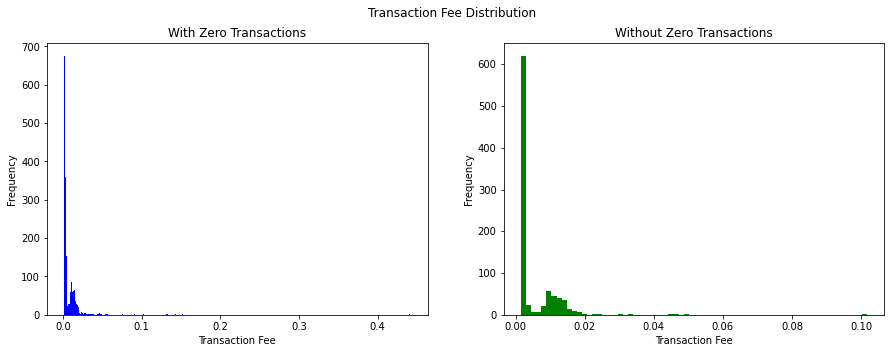

In [15]:
# 3.5 * standard deviation * n^(-1/3)
# bin_width_with_zero_txn = (3.5 * transactionsDf_with_zero_txn['Txn Fee'].std()) / (transactionsDf_with_zero_txn['Txn Fee'].count() ** (1/3))
# bin_size_with_zero_txn = round((transactionsDf_with_zero_txn['Txn Fee'].max() - transactionsDf_with_zero_txn['Txn Fee'].min()) / bin_width_with_zero_txn)

# bin_width_without_zero_txn = (3.5 * transactionsDf_without_zero_txn['Txn Fee'].std()) / (transactionsDf_without_zero_txn['Txn Fee'].count() ** (1/3))
# bin_size_without_zero_txn = round((transactionsDf_without_zero_txn['Txn Fee'].max() - transactionsDf_without_zero_txn['Txn Fee'].min()) / bin_width_without_zero_txn)

# #square root of the number of transactions
# bin_size_with_zero_txn = int(transactionsDf_with_zero_txn['Txn Fee'].count()** (1/2))
# bin_size_without_zero_txn = int(transactionsDf_without_zero_txn['Txn Fee'].count() ** (1/2))

# 2 * IQR * n^(-1/3)
bin_width_with_zero_txn = 2 * (transactionsDf_with_zero_txn['Txn Fee'].quantile(0.75) - transactionsDf_with_zero_txn['Txn Fee'].quantile(0.25)) * transactionsDf_with_zero_txn['Txn Fee'].count() ** (-1/3)
bin_width_without_zero_txn = 2 * (transactionsDf_without_zero_txn['Txn Fee'].quantile(0.75) - transactionsDf_without_zero_txn['Txn Fee'].quantile(0.25)) * transactionsDf_without_zero_txn['Txn Fee'].count() ** (-1/3)
bin_size_with_zero_txn = round((transactionsDf_with_zero_txn['Txn Fee'].max() - transactionsDf_with_zero_txn['Txn Fee'].min()) / bin_width_with_zero_txn)
bin_size_without_zero_txn = round((transactionsDf_without_zero_txn['Txn Fee'].max() - transactionsDf_without_zero_txn['Txn Fee'].min()) / bin_width_without_zero_txn)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Transaction Fee Distribution')

ax[0].hist(transactionsDf_with_zero_txn['Txn Fee'], bins=bin_size_with_zero_txn, color='blue')
ax[0].set_title('With Zero Transactions')
ax[0].set_xlabel('Transaction Fee')
ax[0].set_ylabel('Frequency')

ax[1].hist(transactionsDf_without_zero_txn['Txn Fee'], bins=bin_size_without_zero_txn, color='green')
ax[1].set_title('Without Zero Transactions')
ax[1].set_xlabel('Transaction Fee')
ax[1].set_ylabel('Frequency')

plt.show()


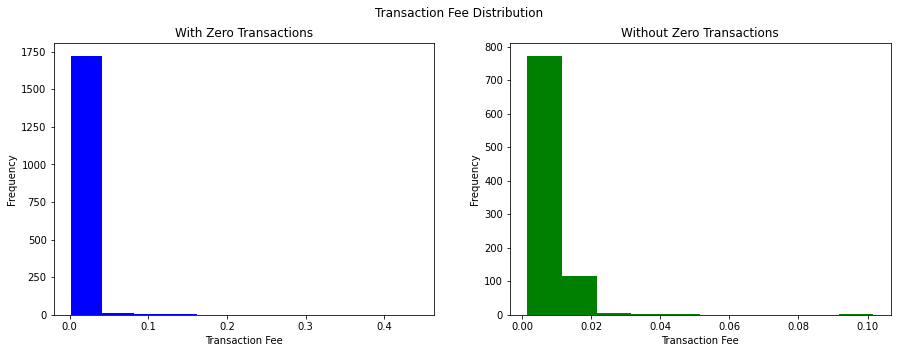

In [16]:

# 1 + log2(n) is the optimal number of bins
bin_size_with_zero_txn = 1 + int(np.log2(transactionsDf_with_zero_txn['Txn Fee'].count()))
bin_size_without_zero_txn = 1 + int(np.log2(transactionsDf_without_zero_txn['Txn Fee'].count()))

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Transaction Fee Distribution')

ax[0].hist(transactionsDf_with_zero_txn['Txn Fee'], bins=bin_size_with_zero_txn, color='blue')
ax[0].set_title('With Zero Transactions')
ax[0].set_xlabel('Transaction Fee')
ax[0].set_ylabel('Frequency')

ax[1].hist(transactionsDf_without_zero_txn['Txn Fee'], bins=bin_size_without_zero_txn, color='green')
ax[1].set_title('Without Zero Transactions')
ax[1].set_xlabel('Transaction Fee')
ax[1].set_ylabel('Frequency')

plt.show()

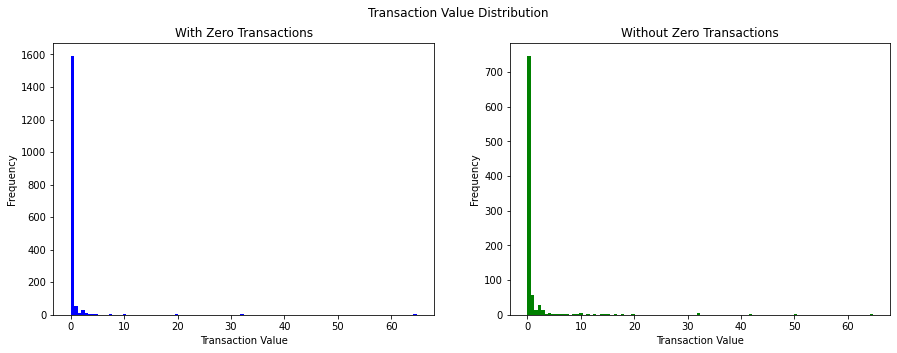

In [20]:

# 2 * IQR * n^(-1/3)
bin_width_with_zero_txn = 2 * (transactionsDf_with_zero_txn['Value'].quantile(0.75) - transactionsDf_with_zero_txn['Value'].quantile(0.25)) * transactionsDf_with_zero_txn['Value'].count() ** (-1/3)
bin_width_without_zero_txn = 2 * (transactionsDf_without_zero_txn['Value'].quantile(0.75) - transactionsDf_without_zero_txn['Value'].quantile(0.25)) * transactionsDf_without_zero_txn['Value'].count() ** (-1/3)
bin_size_with_zero_txn = round((transactionsDf_with_zero_txn['Value'].max() - transactionsDf_with_zero_txn['Value'].min()) / bin_width_with_zero_txn)
bin_size_without_zero_txn = round((transactionsDf_without_zero_txn['Value'].max() - transactionsDf_without_zero_txn['Value'].min()) / bin_width_without_zero_txn)

if bin_size_with_zero_txn > 50:
    bin_size_with_zero_txn = 100
if bin_size_without_zero_txn > 50:
    bin_size_without_zero_txn = 100

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Transaction Value Distribution')

ax[0].hist(transactionsDf_with_zero_txn['Value'], bins=bin_size_with_zero_txn, color='blue')
ax[0].set_title('With Zero Transactions')
ax[0].set_xlabel('Transaction Value')
ax[0].set_ylabel('Frequency')

ax[1].hist(transactionsDf_without_zero_txn['Value'], bins=bin_size_without_zero_txn, color='green')
ax[1].set_title('Without Zero Transactions')
ax[1].set_xlabel('Transaction Value')
ax[1].set_ylabel('Frequency')

plt.show()